### Librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
csv_files = [
    'dataRW/RW9.csv',
    'dataRW/RW10.csv',
    'dataRW/RW11.csv',
    'dataRW/RW12.csv'
]

capacities = []
max_temperatures = []
times_to_max_temp = []
durations = []
cycle_ids = []


for file in csv_files:
    try:
        df = pd.read_csv(file)

        # Verify that the required columns are present
        required_columns = ['Capacity_Ah', 'MaxTemperature_C', 'TimeToMaxTemp_h', 'Duration_h']
        if not all(col in df.columns for col in required_columns):
            print(f"[WARNING] {file} does not contain all required columns.")
            continue

        # Add data to lists
        capacities.append(df['Capacity_Ah'].to_numpy())
        max_temperatures.append(df['MaxTemperature_C'].to_numpy())
        times_to_max_temp.append(df['TimeToMaxTemp_h'].to_numpy())
        durations.append(df['Duration_h'].to_numpy())

        # Convert cycle numbers to float
        cycle_ids.append(np.arange(1, len(df) + 1).astype(float))

        print(f"Processed: {file}")
    except Exception as e:
        print(f"Error in file: {file}: {e}")


max_len = max(len(arr) for arr in capacities)

def pad_array(arr, length):
    return np.pad(arr, (0, length - len(arr)), mode='constant', constant_values=np.nan)

capacities = np.array([pad_array(arr, max_len) for arr in capacities])
max_temperatures = np.array([pad_array(arr, max_len) for arr in max_temperatures])
times_to_max_temp = np.array([pad_array(arr, max_len) for arr in times_to_max_temp])
durations = np.array([pad_array(arr, max_len) for arr in durations])
cycle_ids = np.array([pad_array(arr, max_len) for arr in cycle_ids])

Processed: dataRW/RW9.csv
Processed: dataRW/RW10.csv
Processed: dataRW/RW11.csv
Processed: dataRW/RW12.csv


In [4]:
# Usage example
print("capacities.shape:", capacities.shape)
print("cycle_ids.shape:", cycle_ids.shape)
print("Example - Capacities Battery 1:", capacities[0, :5])
print("Example - Cycle IDs Battery 1:", cycle_ids[0, :5])

capacities.shape: (4, 80)
cycle_ids.shape: (4, 80)
Example - Capacities Battery 1: [2.09773889 2.09466528 2.04456686 2.04085    1.98020827]
Example - Cycle IDs Battery 1: [1. 2. 3. 4. 5.]


#### **Generate Train and Test Sets**

In [5]:
X1 = durations[0, :].reshape(-1, 1)
Y1 = capacities[0, :].reshape(-1, 1)

X2 = durations[1, :].reshape(-1, 1)
Y2 = capacities[1, :].reshape(-1, 1)

X3 = durations[2, :].reshape(-1, 1)
Y3 = capacities[2, :].reshape(-1, 1)

X4 = durations[3, :].reshape(-1, 1)
Y4 = capacities[3, :].reshape(-1, 1)

Xtrain = np.concatenate((X1, X2, X3), axis=0)
Ytrain = np.concatenate((Y1, Y2, Y3), axis=0)
Xtest = X4
Ytest = Y4

#### **MLP Regressor: 2 layers with hidden size 18 and 10**

In [6]:
train_mask = ~np.isnan(Xtrain).any(axis=1) & ~np.isnan(Ytrain).any(axis=1)
Xtrain_clean = Xtrain[train_mask]
Ytrain_clean = Ytrain[train_mask]

test_mask = ~np.isnan(Xtest).any(axis=1) & ~np.isnan(Ytest).any(axis=1)
Xtest_clean = Xtest[test_mask]
Ytest_clean = Ytest[test_mask]

# Battery capacity is the first column in Ytrain and Ytest:
Ytrain_target = Ytrain_clean[:, 0]  
Ytest_target = Ytest_clean[:, 0]

# === MLP Regressor ===
reg = MLPRegressor(
    solver='adam',
    learning_rate_init=0.004,
    hidden_layer_sizes=(18, 10),
    random_state=1,
    max_iter=500
)

# === Training ===
reg.fit(Xtrain_clean, Ytrain_target)

# === Prediction ===
ypred = reg.predict(Xtest_clean)

mse = mean_squared_error(Ytest_target, ypred)
r2 = r2_score(Ytest_target, ypred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0002
R² Score: 0.9974


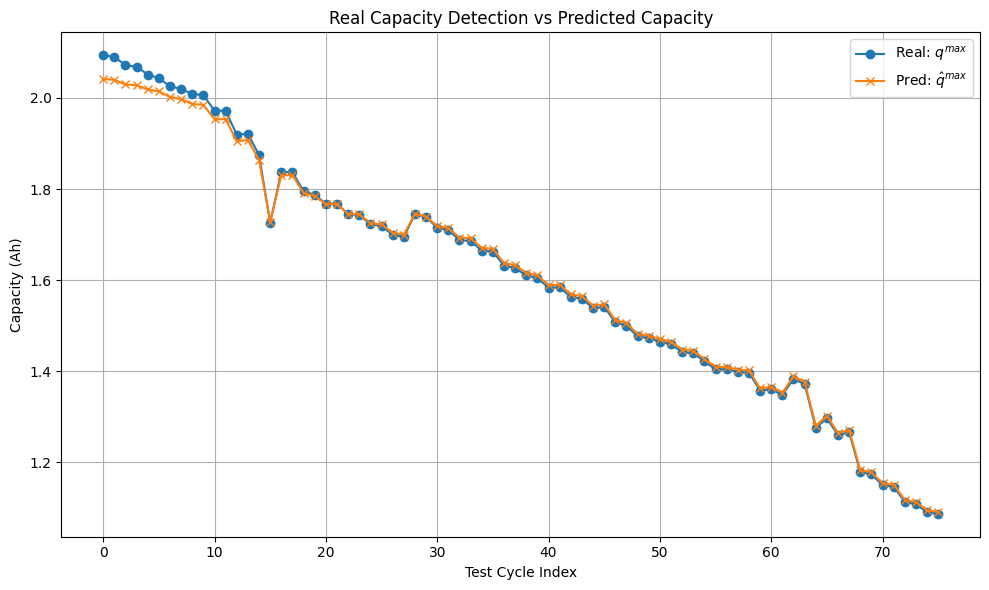

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(Ytest_target, label=r'Real: $q^{max}$', marker='o')
plt.plot(ypred, label=r'Pred: $\hat{q}^{max}$', marker='x')
plt.title('Real Capacity Detection vs Predicted Capacity')
plt.xlabel('Test Cycle Index')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('imgs/data_driven/capacity_prediction.png')
plt.show()